##DBSCAN Fraud Tx

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/bank_transactions_data_2.csv'
data = pd.read_csv(file_path)

# Inspect the data structure
print(data.head())

# Select relevant features for clustering
features = data[['TransactionAmount', 'CustomerAge']]

# Ensure no missing values in the selected features
features = features.dropna()

  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81 

In [ ]:
from sklearn.preprocessing import StandardScaler

X = data[['TransactionAmount', 'CustomerAge']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Unique cluster labels: [-1  0  1  2]
WCSS: 1.7305738645246067
Number of detected frauds: 31
Silhouette Score: 0.33
Calinski-Harabasz Index: 116.51
Davies-Bouldin Index: 0.96


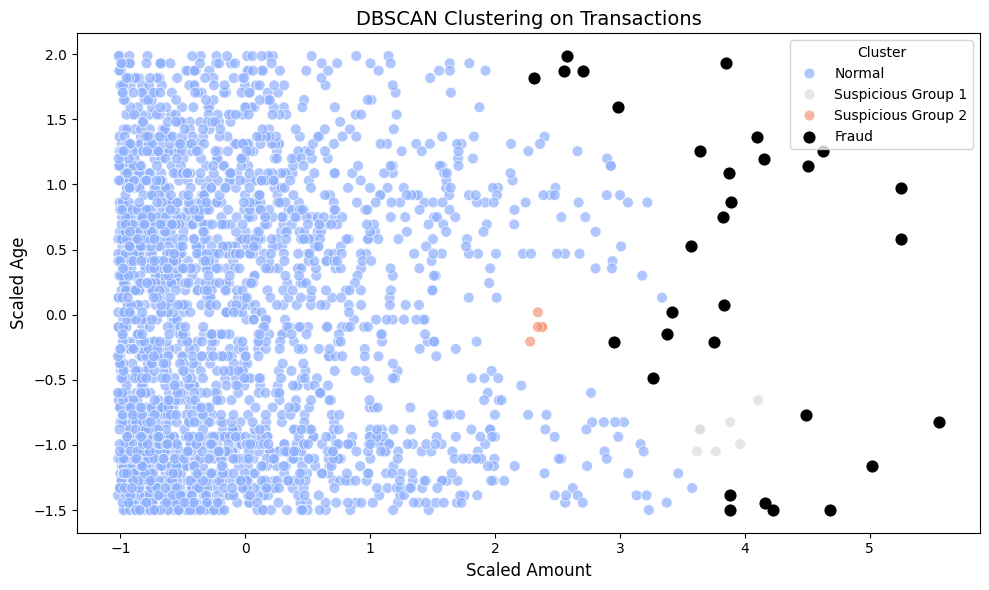

In [ ]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Adjusted DBSCAN clustering with a refined eps value
dbscan = DBSCAN(eps=0.30, min_samples=5)  # Adjust eps based on k-distance elbow
dbscan_labels = dbscan.fit_predict(X_scaled)

unique_labels = np.unique(dbscan_labels)
print(f"Unique cluster labels: {unique_labels}")


def calculate_wcss(data, labels):
    unique_clusters = np.unique(labels[labels != -1])  # Exclude noise (-1 label)
    centroids = np.array([data[labels == i].mean(axis=0) for i in unique_clusters])
    wcss = sum(np.sum((data[labels == i] - centroids[i]) ** 2) for i in range(len(unique_clusters)))
    return wcss

# Calculate WCSS for DBSCAN (ignores noise points)
wcss_bank = calculate_wcss(X_scaled, dbscan_labels)
wcss_bank = wcss_bank / len(X)

print("WCSS:", wcss_bank)

# Add labels to the dataset
data['DBSCAN_Cluster'] = dbscan_labels


# Map the cluster labels to descriptive names
label_mapping = {-1: 'Fraud', 0: 'Normal', 1: 'Suspicious Group 1', 2: 'Suspicious Group 2'}
data['DBSCAN_Cluster'] = data['DBSCAN_Cluster'].map(label_mapping)


# Separate fraud data for custom styling
fraud_data = data[data['DBSCAN_Cluster'] == 'Fraud']
normal_data = data[data['DBSCAN_Cluster'] != 'Fraud']


# Count the number of frauds
num_frauds = (data['DBSCAN_Cluster'] == 'Fraud').sum()
print(f"Number of detected frauds: {num_frauds}")


# Plot normal and suspicious groups with a palette
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[normal_data.index, 0], y=X_scaled[normal_data.index, 1],
                hue=normal_data['DBSCAN_Cluster'], palette='coolwarm', s=60, alpha=0.7)


# Overlay fraud points as black spots
plt.scatter(X_scaled[fraud_data.index, 0], X_scaled[fraud_data.index, 1],
            color='black', s=60, label='Fraud', marker='o')

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scaled, dbscan_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_scaled, dbscan_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X_scaled, dbscan_labels)
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")



# Customize plot
plt.title('DBSCAN Clustering on Transactions', fontsize=14)
plt.xlabel('Scaled Amount', fontsize=12)
plt.ylabel('Scaled Age', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.tight_layout()
plt.show()

###DBSCAN Expedia

WCSS for DBSCAN clustering: 4.30
Silhouette Score: 0.39
Calinski-Harabasz Index: 1886.88
Davies-Bouldin Index: 1.55


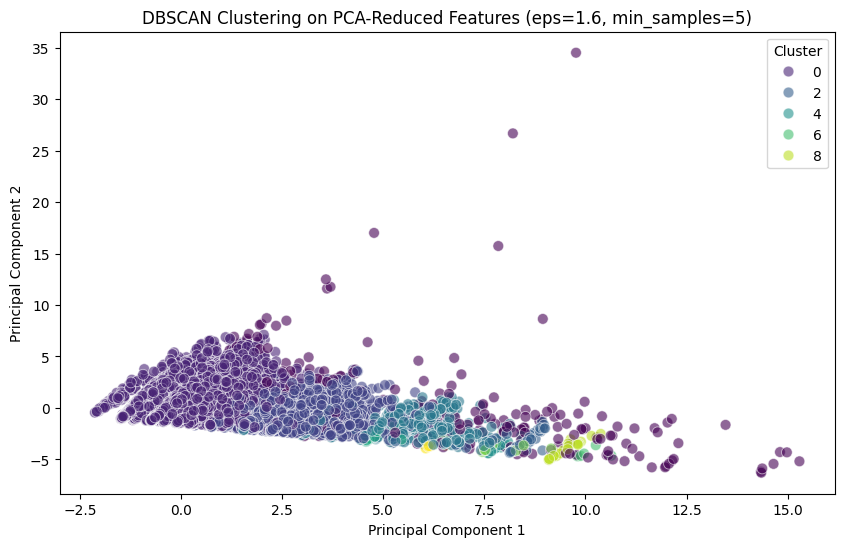

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Load the dataset
file_path = '/content/travel.csv'
data = pd.read_csv(file_path)

# Feature engineering: Calculate 'travel_duration' and 'days_in_advance'
data['srch_ci'] = pd.to_datetime(data['srch_ci'])
data['srch_co'] = pd.to_datetime(data['srch_co'])
data['date_time'] = pd.to_datetime(data['date_time'])

data['travel_duration'] = (data['srch_co'] - data['srch_ci']).dt.days
data['days_in_advance'] = (data['srch_ci'] - data['date_time']).dt.days

# Select relevant features
features = [
    'travel_duration',
    'days_in_advance',
    'orig_destination_distance',
    'srch_adults_cnt',
    'srch_children_cnt',
    'srch_rm_cnt'
]
X = data[features]

# Drop rows with missing values
X = X.dropna()

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering
eps = 1.6  # Adjust `eps` based on your data
min_samples = 5  # Minimum samples in a neighborhood
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add labels to the dataset
data = data.loc[X.index]  # Keep rows corresponding to valid features
data['DBSCAN_Cluster'] = dbscan_labels

# Calculate WCSS (ignoring noise)
def calculate_wcss(data, labels):
    unique_clusters = np.unique(labels[labels != -1])  # Exclude noise (-1 label)
    centroids = np.array([data[labels == i].mean(axis=0) for i in unique_clusters])
    wcss = sum(np.sum((data[labels == i] - centroids[i]) ** 2) for i in range(len(unique_clusters)))
    return wcss

# Calculate WCSS for DBSCAN (ignores noise points)
wcss_travel = calculate_wcss(X_scaled, dbscan_labels)
wcss_travel = wcss_travel / len(X)
print(f"WCSS for DBSCAN clustering: {wcss_travel:.2f}")

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters along the principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='viridis', s=60, alpha=0.6
)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scaled, dbscan_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_scaled, dbscan_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X_scaled, dbscan_labels)
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")

plt.title(f'DBSCAN Clustering on PCA-Reduced Features (eps={eps}, min_samples={min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


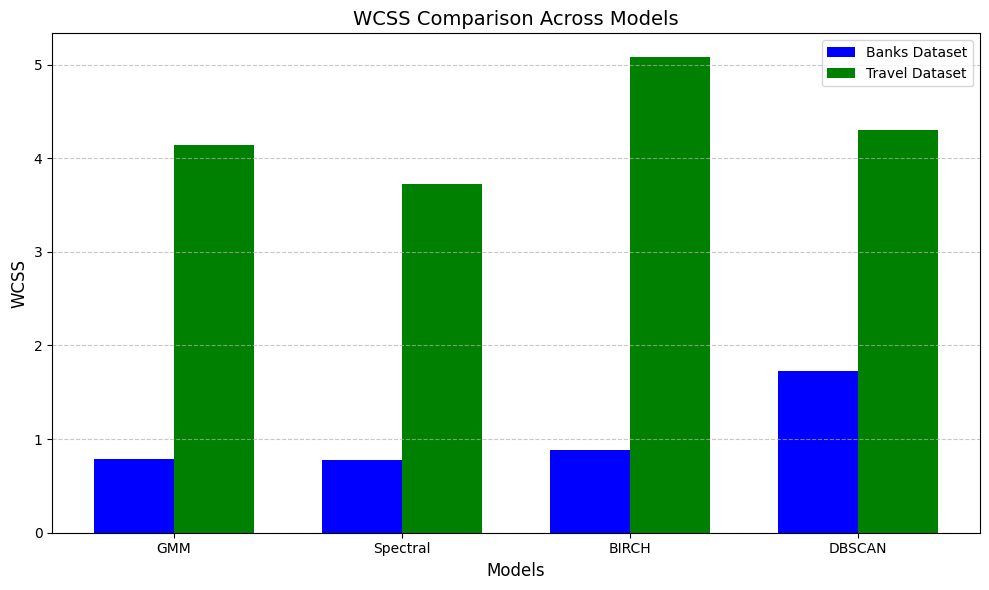

In [ ]:
dts = ["Bank Dataset", "Travel Dataset"]
wcss_banks = [0.79, 0.78, 0.88, 1.73]
wcss_travels = [4.14, 3.73, 5.08, 4.3]
models = ['GMM', 'Spectral', 'BIRCH', 'DBSCAN']  # Names of the models

# Define bar positions
x = np.arange(len(models))  # Positions for models
width = 0.35  # Width of each bar

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wcss_banks, width, label='Banks Dataset', color='blue')
plt.bar(x + width/2, wcss_travels, width, label='Travel Dataset', color='green')

# Add titles and labels
plt.title("WCSS Comparison Across Models", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("WCSS", fontsize=12)
plt.xticks(x, models)  # Set model names on x-axis
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


###DBSCAN synthetic

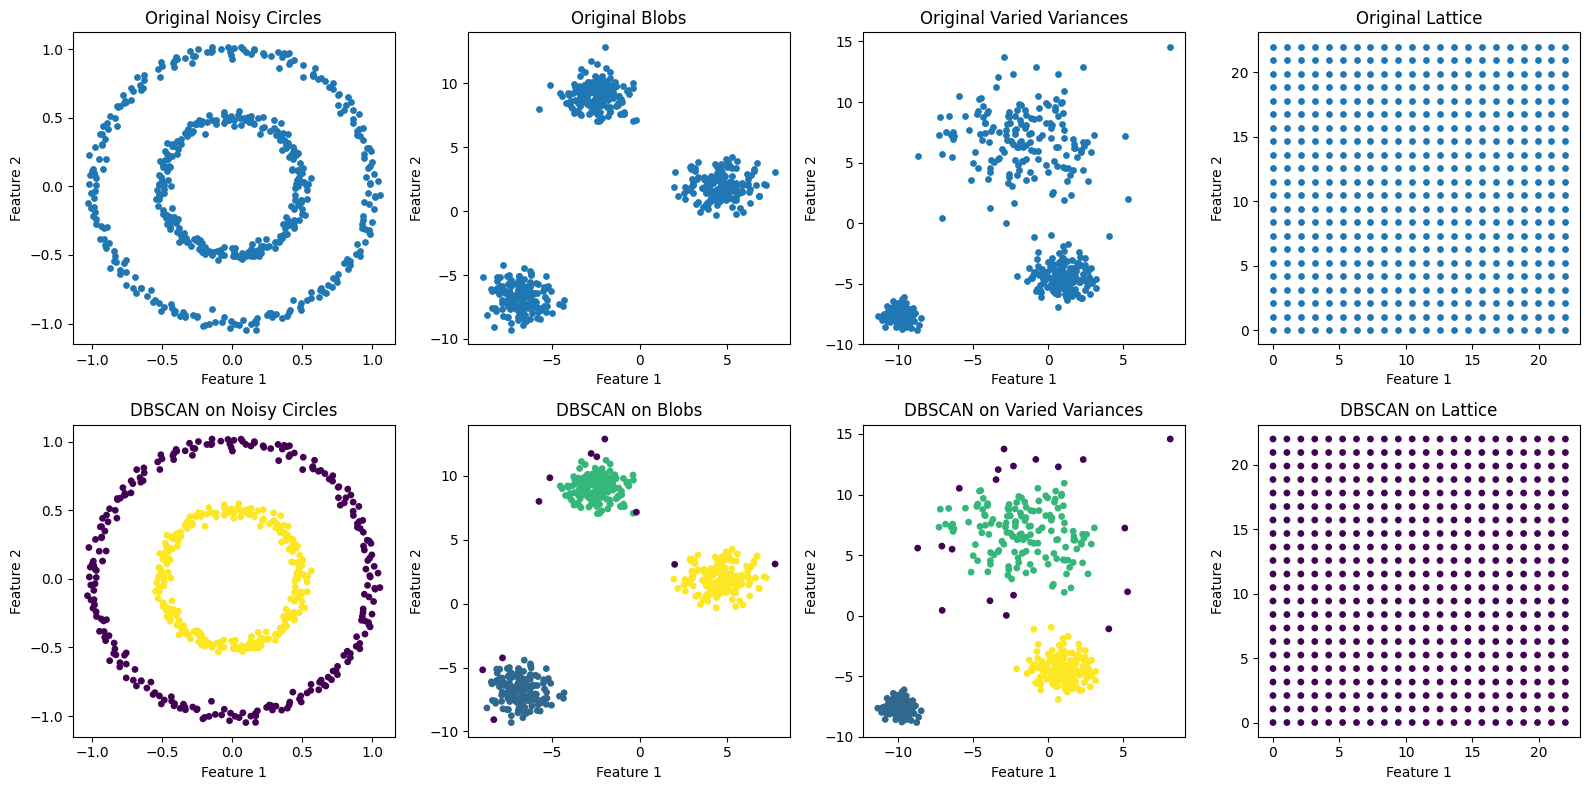

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles, make_blobs
from sklearn.cluster import DBSCAN

# Parameters
n_samples = 500
seed_circles = 4
seed_blobs = 42
seed_varied = 100
grid_size = 22  # Number of points along one dimension of the grid
spacing = 1.0   # Spacing between points in the grid

# Generate noisy circles dataset
noisy_circles, labels_circles = make_circles(
    n_samples=n_samples, factor=0.5, noise=0.03, random_state=seed_circles
)

# Generate blobs dataset
blobs, labels_blobs = make_blobs(
    n_samples=n_samples, centers=3, cluster_std=1.0, random_state=seed_blobs
)

# Generate varied blobs dataset (different cluster_std for each cluster)
varied, labels_varied = make_blobs(
    n_samples=n_samples, centers=3, cluster_std=[1.0, 2.5, 0.5], random_state=seed_varied
)

# Generate lattice dataset
x = np.linspace(0, grid_size * spacing, grid_size)
y = np.linspace(0, grid_size * spacing, grid_size)
xx, yy = np.meshgrid(x, y)
lattice_data = np.c_[xx.ravel(), yy.ravel()]  # Flatten the grid into a 2D array

# Apply DBSCAN to datasets with tuned eps and min_samples
dbscan_circles = DBSCAN(eps=0.3, min_samples=5)
clusters_circles = dbscan_circles.fit_predict(noisy_circles)

dbscan_blobs = DBSCAN(eps=0.8, min_samples=5)
clusters_blobs = dbscan_blobs.fit_predict(blobs)

dbscan_varied = DBSCAN(eps=1.3, min_samples=5)
clusters_varied = dbscan_varied.fit_predict(varied)

dbscan_lattice = DBSCAN(eps=1, min_samples=5)
clusters_lattice = dbscan_lattice.fit_predict(lattice_data)

# Combine datasets and clustering results
datasets = [
    (noisy_circles, clusters_circles, "Noisy Circles"),
    (blobs, clusters_blobs, "Blobs"),
    (varied, clusters_varied, "Varied Variances"),
    (lattice_data, clusters_lattice, "Lattice"),
]

# Create a 2x4 plot layout
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Plot original datasets in the first row
for i, (data, clusters, title) in enumerate(datasets):
    axes[0, i].scatter(data[:, 0], data[:, 1], s=15)
    axes[0, i].set_title(f"Original {title}")
    axes[0, i].set_xlabel("Feature 1")
    axes[0, i].set_ylabel("Feature 2")

# Plot DBSCAN results in the second row
for i, (data, clusters, title) in enumerate(datasets):
    axes[1, i].scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', s=15)
    axes[1, i].set_title(f"DBSCAN on {title}")
    axes[1, i].set_xlabel("Feature 1")
    axes[1, i].set_ylabel("Feature 2")

# Adjust layout and show plots
plt.tight_layout()
plt.show()


###DBSCAN metrics

WCSS Results:
Noisy Circles: 312.22
Blobs: 1683.41
Varied Variances: 2851.38

Accuracy Results:
Noisy Circles: 1.00
Blobs: 0.98
Varied Variances: 0.96


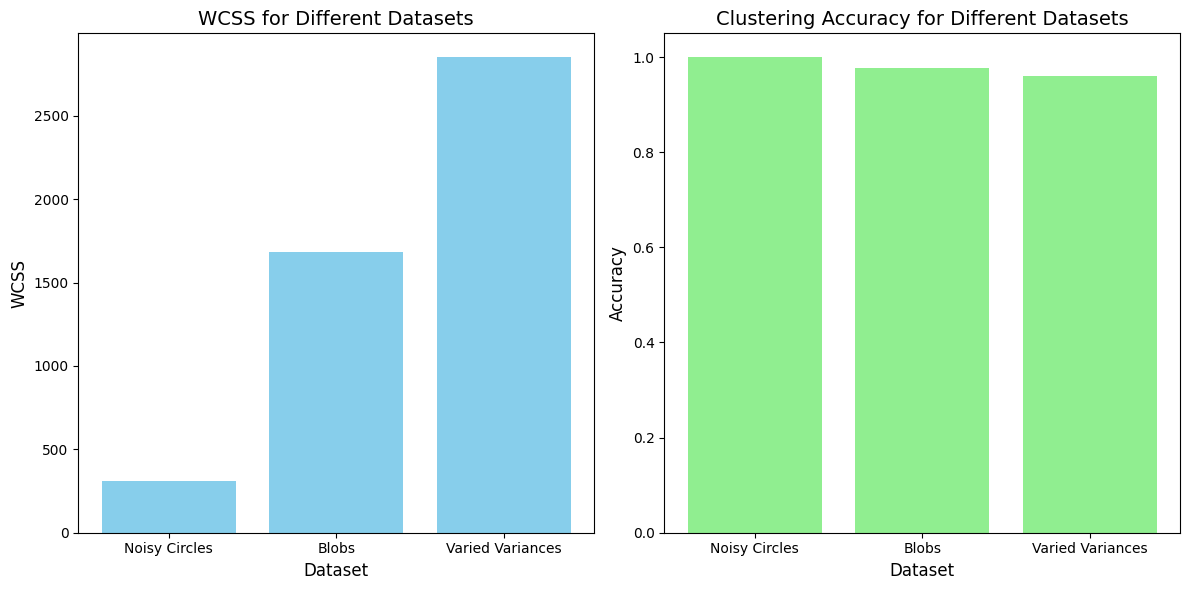

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles, make_blobs
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

# Parameters
n_samples = 500
seed_circles = 4
seed_blobs = 42
seed_varied = 100

# Generate datasets
noisy_circles, labels_circles = make_circles(
    n_samples=n_samples, factor=0.5, noise=0.03, random_state=seed_circles
)

blobs, labels_blobs = make_blobs(
    n_samples=n_samples, centers=3, cluster_std=1.0, random_state=seed_blobs
)

varied, labels_varied = make_blobs(
    n_samples=n_samples, centers=3, cluster_std=[1.0, 2.5, 0.5], random_state=seed_varied
)

datasets = [
    (noisy_circles, labels_circles, "Noisy Circles", 0.3, 5),
    (blobs, labels_blobs, "Blobs", 0.8, 5),
    (varied, labels_varied, "Varied Variances", 1.3, 5),
]

# Functions to calculate WCSS and accuracy
def calculate_wcss(data, labels):
    """Calculate Within-Cluster Sum of Squares (WCSS)."""
    wcss = 0
    for cluster in np.unique(labels):
        #if cluster == -1:  # Skip noise points
        #    continue
        cluster_points = data[labels == cluster]
        centroid = cluster_points.mean(axis=0)
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

def calculate_accuracy(true_labels, predicted_labels):

    unique_true = np.unique(true_labels)
    unique_pred = np.unique(predicted_labels)
    cost_matrix = np.zeros((len(unique_true), len(unique_pred)))
    for i, true_label in enumerate(unique_true):
        for j, pred_label in enumerate(unique_pred):
            cost_matrix[i, j] = -np.sum((true_labels == true_label) & (predicted_labels == pred_label))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return -cost_matrix[row_ind, col_ind].sum() / len(true_labels)

# Initialize lists to store WCSS and accuracy
wcss_list = []
accuracy_list = []

# Apply DBSCAN clustering and compute WCSS and accuracy
for data, true_labels, name, eps, min_samples in datasets:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    predicted_labels = dbscan.fit_predict(data)

    # Calculate WCSS
    wcss = calculate_wcss(data, predicted_labels)
    wcss_list.append((name, wcss))

    # Calculate accuracy
    accuracy = calculate_accuracy(true_labels, predicted_labels)
    accuracy_list.append((name, accuracy))

# Print WCSS and accuracy results
print("WCSS Results:")
for name, wcss in wcss_list:
    print(f"{name}: {wcss:.2f}")

print("\nAccuracy Results:")
for name, accuracy in accuracy_list:
    print(f"{name}: {accuracy:.2f}")

# Plot WCSS and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot WCSS
datasets_names = [name for name, _ in wcss_list]
wcss_values = [wcss for _, wcss in wcss_list]
axes[0].bar(datasets_names, wcss_values, color='skyblue')
axes[0].set_title("WCSS for Different Datasets", fontsize=14)
axes[0].set_ylabel("WCSS", fontsize=12)
axes[0].set_xlabel("Dataset", fontsize=12)

# Plot Accuracy
accuracy_values = [accuracy for _, accuracy in accuracy_list]
axes[1].bar(datasets_names, accuracy_values, color='lightgreen')
axes[1].set_title("Clustering Accuracy for Different Datasets", fontsize=14)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].set_xlabel("Dataset", fontsize=12)

plt.tight_layout()
plt.show()
